Kilian Cannet - Noe Boonstra

# Importation

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

Done


# Chargement données

In [42]:
#https://www.kaggle.com/priteshshrivastava/sample-github-code
data = pd.read_csv("sample_code.csv", lineterminator='\n',names=['content','lang'])
data.head(10)

,content,lang
0,content,type
1,// Utility.cs\n//\n\nusing System;\nusing Syst...,cs
2,\n{$options.identity.sitename} - Your Accounts...,txt
3,"{\n ""name"": ""opulence/sessions"",\n ""descript...",json
4,package io.mycat.backend.postgresql.packet;\r\...,java
5,TAPi18n._afterUILanguageChange = function() {\...,js
6,"filter:\n paths: [""src/*""]\ntools:\n ext...",yml
7,/**\n * \n */\npackage org.openrtb.dsp.intf.mo...,java
8,"{% extends ""json/page.json"" %}\n{% block title...",json
9,<?php\n\nnamespace JMS\SecurityExtraBundle\Sec...,php


### Filtrage des donnees

In [43]:

#Reduire taille trop grande
print(data.shape)
len_cond = [True if 20<=len(s)<=10000 else False for s in data['content']]
data = data[len_cond]

# Filtrer
lang = ['csv', 'txt', 'java', 'cs', 'py', 'cpp','c','js','php']
data = data[data['lang'].isin(lang)]

data_trim= pd.DataFrame(data=data)

'''
for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = data_trim.append(lang_trim)
'''
# Melanger
print(data.shape)
data_shuffle = data_trim.sample(frac=1)

maxim = data_shuffle.shape[0]
percent = 0.8
part = int(maxim*percent)
train = data_shuffle[0:part]
valid = data_shuffle[part:maxim]

(681919, 2)
(201974, 2)


In [9]:
print("taille du training : ",train.shape[0])
print("taille du validation : ",valid.shape[0])
print()
# Variete des donnees
grouped = data_trim.groupby('lang').count().sort_values('content')
print("Quantite de sample par langage :")
print(grouped)
print()
print("Pourcentage de sample par langage :")
print(grouped.div(data_trim.shape[0]))

taille du training :  161579
taille du validation :  40395

Quantite de sample par langage :
      content
lang         
csv      1558
cpp      6573
c        9960
py      19486
cs      22891
txt     25966
php     27012
java    39064
js      49464

Pourcentage de sample par langage :
       content
lang          
csv   0.007714
cpp   0.032544
c     0.049313
py    0.096478
cs    0.113336
txt   0.128561
php   0.133740
java  0.193411
js    0.244903


In [72]:
#Donnes Vectorisees et Assignee suivant Frequences
#On utilisera des pipeline par la suite

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train["content"])
print(count_vect.get_feature_names()[0:10])#Affiches les premiers mots
skline = count_vect.vocabulary_.get(u'sklearn')#Affiche indice de sklearn
print(count_vect.get_feature_names()[skline])#affiche sklearn
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#Mots les plus frequents

sum_words = X_train_counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:10])


['00', '000', '0000', '00000', '000000', '0000000', '00000000', '000000000', '0000000000', '00000000000']
sklearn
[('the', 201520), ('public', 151384), ('this', 118145), ('import', 97792), ('return', 96364), ('license', 91372), ('function', 85777), ('class', 78705), ('of', 68094), ('is', 64944)]


# Training avec Modeles

#### Comparaison modeles

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [32]:
#[!] Attention ce script prend BEAUCOUP de temps
#Lance un warning mais pas important
import time


names = [
        "SGD Classif",
        "MultiBayes"
        "AdaBoost",
        "RBF SVM",
         "Decision Tree",
        "Random Forest"
]

classifiers = [
    SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None),
    MultinomialNB(),
    AdaBoostClassifier(n_estimators=5),# ok
    SVC(gamma=2, C=1, max_iter=8),#ok tres long
    DecisionTreeClassifier(max_depth=3),#ok
    RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1)#ok
    
]

rows = []
trainScore = []
validScore = []
i =1

t0 = time.time()
for name, clff in zip(names, classifiers):
    print("Training ... (",i,"/",len(classifiers),")")
    clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clff),
    ])
    clf.fit(train["content"],train["lang"])
    score = clf.score(train["content"], train["lang"])
    
    trainScore.append(clf.score(train["content"],train["lang"]))
    validScore.append(clf.score(valid["content"],valid["lang"]))
    i = i+1


t1 = time.time()
total = t1-t0
print("duration : ",total)
data= [trainScore, validScore]
ptable = pd.DataFrame(data, columns=names)
display(ptable)

Training ... ( 1 / 6 )
Training ... ( 2 / 6 )
Training ... ( 3 / 6 )
Training ... ( 4 / 6 )


C:\Users\kilca\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training ... ( 5 / 6 )
duration :  486.5661189556122


,SGD Classif,MultiBayesAdaBoost,RBF SVM,Decision Tree,Random Forest
0,0.914382,0.876636,0.694626,0.140594,0.653297
1,0.910558,0.847605,0.692214,0.150439,0.651392


## Modele Multi Bayonesien

### Modele Bayonesien a la Main

In [6]:
# Todo, reprendre le modele bayonesien a la main ([!] multi bayesien peut etre different de bayesien)

### Modele Bayonesien Sklearn

In [7]:
clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.8764814734588035
0.846936502042332


## Modele SGDClassifier

In [44]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None)),
])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.9146361841575947
0.9148409456615918


In [ ]:
print(valid.columns)
print(valid.head(2))
print()
print(ptable.columns)
print(ptable.head(2))
print()
print(lang)

# Recherche hyperparametre sur SGD Classifier :

#### Nos Recherches ([!] Prend beaucoup de temps)

[0.9867247600245082, 0.9608364948415327, 0.9146361841575947, 0.881030331911944, 0.4313369930498394, 0.1940660605648011, 0.19342241256598938]


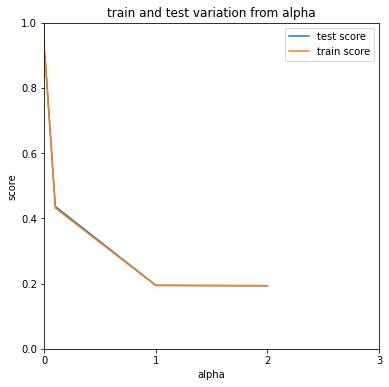

In [133]:
#PS : use_idf ou non change pas bcp
#Changement d'alpha

alpha_range = [0.00001,0.0001,0.001,0.01,0.1,1.0,2.0]

trainList = []
testList = []

for A in alpha_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        random_state=42,alpha=A,
                          max_iter=5, tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))

print("score des tests :")
print(testList)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.xlim(0,2)
ax.set_ylim([0,1])
plt.xticks(range(0,3))
ax.set_title('train and test variation from alpha');
plt.xlabel('alpha')
plt.ylabel('score') 
ax.plot(alpha_range,testList, label="test score")
ax.plot(alpha_range,trainList, label="train score")
ax.legend()

In [136]:
#Loss
loss_range = ['hinge','log','modified_huber','squared_hinge','perceptron']


trainList = []
testList = []

for L in loss_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss=L, penalty='l2',
                        random_state=42,
                          max_iter=5,tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))

ptable = pd.DataFrame([trainList,testList], columns=loss_range)
print("Training Score (0) et Valid Score (1) suivant les types de loss_range")
display(ptable)

,hinge,log,modified_huber,squared_hinge,perceptron
0,0.960836,0.924235,0.973629,0.893223,0.997840
1,0.954994,0.928481,0.964005,0.904518,0.967892


In [137]:
#Penalty

penalty_range = ['l2','l1','elasticnet']

trainList = []
testList = []

for P in penalty_range:
    clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty=P,
                        random_state=42,
                          max_iter=5,tol=None)),
    ])

    clf = clf.fit(train["content"],train["lang"])
    trainList.append(clf.score(train["content"],train["lang"]))
    testList.append(clf.score(valid["content"],valid["lang"]))
    
ptable = pd.DataFrame([trainList,testList], columns=penalty_range)
print("Training Score (0) et Valid Score (1) suivant les types de penalty_range")
display(ptable)


,l2,l1,elasticnet
0,0.960836,0.938785,0.948261
1,0.954994,0.941156,0.948830


In [138]:
#Best estimé (on espere)

clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),#use_idf=True est mieu (et change peu)
    ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                    random_state=42,
                      max_iter=5,tol=None, alpha=0.000001)),
])

clf = clf.fit(train["content"],train["lang"])
print("training score :",clf.score(train["content"],train["lang"]))
print("valid score :",clf.score(valid["content"],valid["lang"]))

training score : 0.9986879483101145
valid score : 0.9694516648100012


#### Recherche avec GridSearchCV

In [ ]:
# Todo determiner meilleur hyperparam avec GridSearchCV

# Analyse des resultat et des metriques

In [105]:
#Prend pas mal de temps

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import numpy as np

from sklearn.model_selection import KFold, cross_val_score

scores = cross_val_score(
    clf, train["content"], train["lang"], cv=5)

print("differents scores cross_validate : ")
print(scores)
print("moyenne des scores :",np.mean(scores))

print("train score :",clf.score(train["content"],train["lang"]))
print("test score : ",clf.score(valid["content"],valid["lang"]))

differents scores cross_validate : 
[0.96608491 0.96456863 0.96645624 0.96828197 0.96630048]
moyenne des scores : 0.9663384472117815
train score : 0.9986879483101145
test score :  0.9694516648100012


In [17]:
#Attention prend beaucoup de temps

cross_v = cross_validate(clf, train["content"], train["lang"], cv=5, return_train_score=True)
print(cross_v)

{'fit_time': array([16.24347949, 15.9299047 , 17.07711411, 15.9575386 , 17.76930308]), 'score_time': array([3.32822394, 3.397686  , 3.62943673, 3.38888597, 3.51273656]), 'test_score': array([0.83905805, 0.83744894, 0.84060527, 0.84066716, 0.84217855]), 'train_score': array([0.87414805, 0.87267818, 0.87366841, 0.8735369 , 0.87366939])}


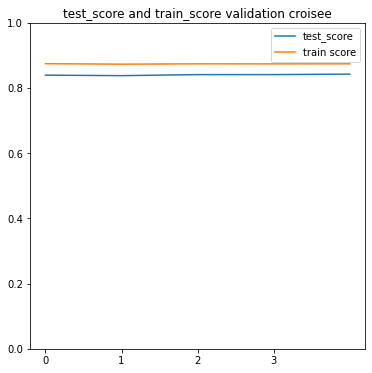

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_ylim([0,1])
plt.xticks(range(0,4))
ax.plot(cross_v['test_score'],label = "test_score")
ax.set_title('test_score and train_score validation croisee');
ax.plot(cross_v['train_score'], label="train score")
ax.legend()

In [98]:
y_true = valid["lang"]
y_pred = clf.predict(valid["content"])

[[  68  171    8    2    2    0    1   43    2]
 [   1 4694   94   11   30   14    7  255   55]
 [   0   16 7771    4    1    1    3   10    5]
 [   0   13   37 4516    0    1    2    7    0]
 [   0  117   66    4 3657    2    3   80    5]
 [   0   43   36   50    5  875  206   58    2]
 [   0   39    8    0    4   27 1874   33    1]
 [   0   83   35    7   40    3    1 9729   23]
 [   0   39   24    3    5    1    1   94 5267]]


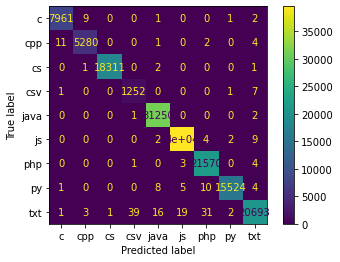

In [139]:

# Matrice de confusion
print(confusion_matrix(y_true, y_pred, labels=lang))
plot_confusion_matrix(clf, train["content"], train["lang"])
plt.show()

In [100]:
#MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true,y_pred)
print(mcc)

0.9428102891306134


In [76]:
#Todo ROC + AUC si possible

In [101]:
y_true =  valid["lang"]
y_pred = clf.predict(valid["content"])
target_names = lang
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         csv       0.89      0.94      0.92      1986
         txt       0.95      0.69      0.80      1275
        java       0.98      0.99      0.98      4576
          cs       0.99      0.23      0.37       297
          py       0.96      0.99      0.98      7811
         cpp       0.94      0.98      0.96      9921
           c       0.98      0.97      0.98      5434
          js       0.98      0.93      0.95      3934
         php       0.90      0.91      0.90      5161

    accuracy                           0.95     40395
   macro avg       0.95      0.85      0.87     40395
weighted avg       0.95      0.95      0.95     40395



## Tests persos

In [142]:
clf.predict([
"public class Main{ \
    public static void main(String[] args) {\
    System.out.println(\"blabla\");\
    }"
    ])[0]

'java'

In [144]:
clf.predict([
"\
#include <iostream>\
#define e using\
#define ee namespace\
#define eee std\
#define eeee ;\
#define eeeee int\
#define eeeeee main\
#define eeeeeee (\
#define eeeeeeee )\
#define eeeeeeeee while\
#define eeeeeeeeee true\
#define eeeeeeeeeee {\
#define eeeeeeeeeeee }\
#define eeeeeeeeeeeee cout\
#define eeeeeeeeeeeeee cerr\
#define eeeeeeeeeeeeeee <<\
#define eeeeeeeeeeeeeeee 'e'\
#define eeeeeeeeeeeeeeeee return\
\
e ee eee eeee\
eeeee eeeeee eeeeeee eeeeeeee\
eeeeeeeeeee\
eeeeeeeee eeeeeee eeeeeeeeee eeeeeeee\
eeeeeeeeeee\
eeeeeeeeeeeee eeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeeeee eeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeee\
eeeeeeeeeeeeeeeee eeeeeeeeeeeeeeee eeee\
eeeeeeeeeeee"
    ])[0]

'cpp'